# Example for retrieving ECCC CMC data 

In [23]:
import numpy as np
from urllib.request import urlopen
import pygrib
from bs4 import BeautifulSoup
import requests
from io import BytesIO
import urllib
import tempfile
import os
import datetime as dt   
import numpy as np
import pandas as pd
import xarray as xr
import gzip
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import io

In [8]:
current_date = dt.datetime.utcnow()
init_hour = 12
model = 'hrdps'
variable = 'tmp'
levtype = 'agl'
level = 2
fc_hour = 18

In [9]:
model_url = f'https://dd.weather.gc.ca/model_{model}/continental/2.5km/\
grib2/{str(init_hour).zfill(2)}/{str(fc_hour).zfill(3)}/'

In [10]:
def get_valid_files(model_url, variable, levtype, level = None):
    
    """
    """

    soups = BeautifulSoup(requests.get(model_url).text,'html.parser')
    files = [soup.string for soup in soups.find_all("a") if soup.string.endswith('grib2')]
    valid_files = []
    for i,file in enumerate(files):
        if file.replace("-","_").split("_")[-4].lower() == levtype.lower():
            if file.split("_")[3].lower() == variable.lower() and \
                        int("".join([f for f in file.replace('-','_').split("_")[-3] \
                                     if f.isnumeric()])) == level:
        
                valid_files.append(file)
    return valid_files

In [11]:
file_urls = get_valid_files(model_url, variable, levtype, level)
file_urls

['20221031T12Z_MSC_HRDPS_TMP_AGL-2m_RLatLon0.0225_P018.grib2']

In [37]:
url = f"{model_url}{file_urls[0]}"
data = requests.get(url,stream = True)   
tmp = io.BufferedIOBase()
tmp = tempfile.NamedTemporaryFile(suffix = '.grb')
for chunk in data.iter_content(chunk_size=128):
    tmp.write(chunk)
tmp.flush()

In [38]:
def get_params(file):
    d = {'name' : [] , 'shortName' : [], 'typeOfLevel' : [], 'level' : [], 'paramId' : [], 'units' : []}

    with pygrib.open(file) as grbs:
        for grb in grbs:
        # print(grb.shortName)
            d['name'].append(grb.name)
            d['shortName'].append(grb.shortName)
            d['typeOfLevel'].append(grb.typeOfLevel)
            d['level'].append(grb.level)
            d['paramId'].append(grb.paramId)
            d['units'].append(grb.units)
    
    df = pd.DataFrame(d)
    return df

In [39]:
grib_kwrgs = get_params(tmp.name).to_dict('records')
ds = xr.open_dataset(tmp.name, engine = 'cfgrib', \
                     backend_kwargs = dict(filter_by_keys=grib_kwrgs[0]))#.load()
# os.unlink(tmp.name)

/home/chris/anaconda3/envs/metr/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


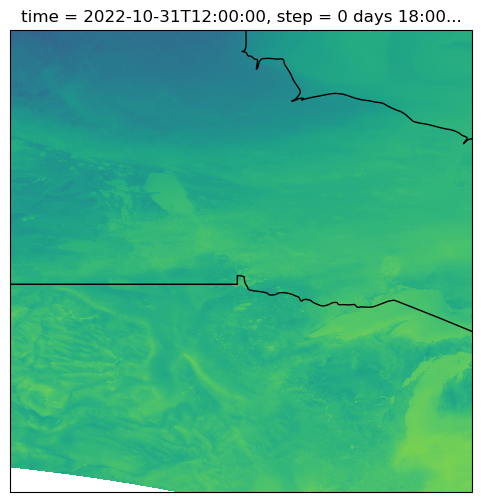

In [40]:
plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds['t2m'].plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", add_colorbar=False
)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
ax.set_ylim([40, 60]);
ax.set_xlim([-105, -85]);

In [35]:
tmp.name

'/tmp/tmpiuvvuhue.grb'

In [36]:
tmp.close()